In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from typing import List
from matplotlib.colors import TABLEAU_COLORS
import os
from tqdm.auto import tqdm
from matplotlib.patches import FancyBboxPatch

In [2]:
df = pd.read_csv("tests/test_case.csv", index_col=0)
df = df[df.syntetic_negatives==0]
df = df.drop(columns="syntetic_negatives")
index = ["dataset", "resource", "model"]
df = df.drop(columns=df.columns.difference(index+["test_auroc"]))
df = df.groupby(index).agg(["mean", "std"])

In [3]:
def is_last(df:pd.DataFrame, index:int)->bool:
    return index+1 == df.shape[0]

In [4]:
def sanitize_name(name:str)->str:
    return str(name).replace("_", " ").capitalize()

In [23]:
def histogram_width(indices:List, bar_width:float):
    return sum(
        sum([
            new != old or is_last(df, i)
            for j, (new, old) in enumerate(zip(index[:-1], old_index))
        ])*bar_width*(not is_last(df, i)) + bar_width
        for i, index in enumerate(indices)
    )

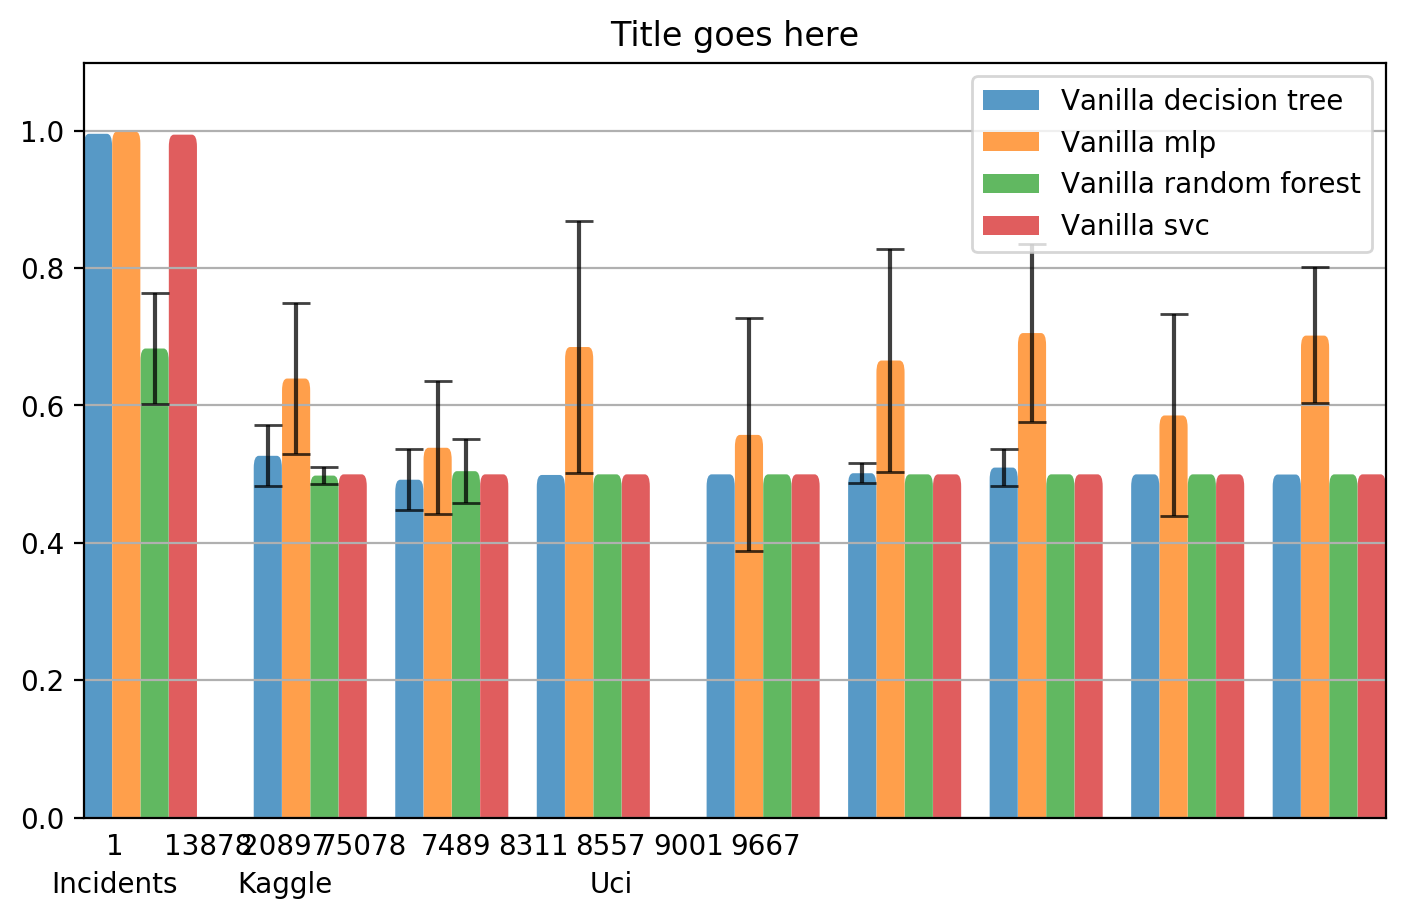

In [29]:
bar_width=0.1
increase=1.5
height=5
min_std = 0.01

levels = [
    list(e) for e in df.index.levels
]
indices = [len(x) for x in levels]
colors = list(TABLEAU_COLORS.keys())

width = histogram_width(df.index, bar_width)
fig, axis = plt.subplots(figsize=(
    width,
    height
), dpi=200)

labels_offsets = {}
labels_index = {}
old_index = []
x = 0
for i, (index, (mean, std)) in enumerate(df["test_auroc"].iterrows()):
    jumps = [
        new != old or is_last(df, i)
        for j, (new, old) in enumerate(zip(index[:-1], old_index))
    ]
    
    for j, value in enumerate(jumps):
        if value:
            text_x = (
                x +
                (labels_offsets[j] if j in labels_offsets else 0) +
                (bar_width if is_last(df, i) else 0)
            )/2
            axis.text(
                text_x,#/width,
                (-len(jumps)+j)/20,
                sanitize_name(old_index[j]),
                horizontalalignment='center',
                #transform=axis.transAxes
            )
    extra_space = sum(jumps)*bar_width*(not is_last(df, i))
    x = round(x + extra_space, 5)
    for j, value in enumerate(jumps):
        if value:
            labels_offsets[j] = x
    old_index = index
    axis.bar(
        x + bar_width/2,
        mean+1,
        bottom=-1,
        **({"yerr": std} if std > min_std else {}),
        color=colors[list(levels[-1]).index(index[-1])],
        error_kw={
            "ecolor":"black",#colors[list(levels[-1]).index(index[-1])],
            "alpha":0.75
        },
        width=bar_width,
        capsize=5,
        alpha=0.75,
        label=sanitize_name(index[-1])
    )
    x += bar_width

axis.yaxis.grid(True, which="both")
axis.set_xlim(0, x)
axis.set_ylim(0)
axis.set_xticks([])
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axis.legend(by_label.values(), by_label.keys(), loc='best')
axis.set_title("Title goes here")

#fig.savefig("{path}/{feature}.jpg".format(
#    path=path,
#    feature=feature
#))


for patch in reversed(axis.patches):
    bb = patch.get_bbox()
    p_bbox = FancyBboxPatch(
        (bb.xmin, bb.ymin),
        abs(bb.width), abs(bb.height),
        boxstyle="round,pad=-0.0003,rounding_size=0.0175",
        ec="none",
        fc=patch.get_facecolor(),
        mutation_aspect=1
    )
    patch.remove()
    axis.add_patch(p_bbox)